In [1]:
from Bio import AlignIO
from Bio.Align import AlignInfo 
from multiprocessing import Pool
from Bio import motifs
from Bio.Seq import Seq
import pickle
import numpy as np
import glob
import os 
import pandas as pd
from Bio import SeqIO
import csv
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

def getPosition_Probability_Matrix(_matrix):
    num_columns = len(_matrix[0])
    keys = _matrix.keys()
   # print(num_columns)
    d = {}

    for i in range(num_columns):
        #print("postion:"+str(i))
        sub_dict = {}
        for char in keys:
            if _matrix[char][i] != 0 :
                sub_dict[char] =  round(_matrix[char][i],4)
        
        d[i]=(sub_dict)
        #cleaned = set(n for n in value if n != 0) 
        #d[key] = cleaned
    
    #cleaned = [tuple(n for n in sublist if n != 0) for sublist in _matrix]
    return d

def calculateProtien_PositionSpecificScoringMatrix(sequence, predefine_matrix):
    scores = 0
    score= 0
    raw_score = 0
    max_score = pssm.max
    min_score = pssm.min
    for i in range( len(sequence) ):
        score =predefine_matrix[sequence[i]][i]
        scores += score
        raw_score += score
        rel_score = (score - min_score) / (max_score - min_score)
        print("Position %d: score = %5.4f, rel. score = %5.4f" % (
            i, score, rel_score))
    print("Max_raw_score:"+ str(max_score) ) 
    print("Min_raw_score:"+ str(min_score) ) 
    print("raw_score:"+ str(raw_score) )   
    rel_score = (scores - min_score) / (max_score - min_score)
    return rel_score

def convert_protein_pwm(sequence):
    m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")  
    index_pattern = [char for char in m.consensus]
    pwm = m.counts.normalize(pseudocounts=0.5)
    pwm_df = pd.DataFrame.from_dict(pwm)
    pwm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
    # Sum value of column A...Y 
    # For example. sum value of 
    for  char in char_code_list: # column
        for index, row in pwm_df.iterrows():
            result_df.loc[index, char] += row[char]
    _flat = result_df.values.flatten()

    return _flat, pwm_df, result_df

from pathlib import Path
def scale_by(x_ar):
    # sigmod function 
    return 1 / (1 + np.exp(x_ar * -1)) 

def NormalizeData(x,_min,_max):
    return  (x - _min) / (_max - _min) 

def NormalizeData_V1(x):
    return  (x - x.min()) / (x.max() - x.min()) 



def convert_to20X20_(pssm , index_pattern):
    """
    
    pssm: dcit
        get pssm as dict 
    """
    pssm_df = pd.DataFrame.from_dict(pssm)
    pssm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])
    for  char in char_code_list: # column
        for index, row in pssm_df.iterrows():
            result_df.loc[index, char] += round(row[char],2)
    return result_df

def get_pssm(m):
    pwm = m.counts.normalize(pseudocounts=0.5)
    pssm = pwm.log_odds()
    return pssm

def create_image(df,file):
    plt.axis("off")
    plt.imshow(df)
    plt.savefig(file, bbox_inches='tight', pad_inches=0)

In [3]:
from os import getpid
from functools import partial

num_partitions = 24 #number of partitions to split dataframe 22
num_cores = 24 #number of cores on your machine 22

def convert_pssm(df):
    process_id =str(getpid())
    path = "/mnt/vdb/thesis/pwm/NonAMP/"
    pro_plk= path + "chunk"+process_id+".pkl"
    if not os.path.exists(path):
        os.makedirs(path)
    
    print(process_id+" Start")

    char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

    ready_df = pd.DataFrame(columns = ['ID', 'Sequence','reps', 'length'])
    for index, seq_record in df.iterrows():
        #print(seq_record)
        m = motifs.create([ seq_record["Sequence"] ] , alphabet="ACDEFGHIKLMNPQRSTVWY")  
        index_pattern = [char for char in m.consensus]
        
        file_name = '/mnt/vdb/thesis/pwm/images/NonAMP/'+seq_record["ID"]+'.png'
        pssm = get_pssm(m)
        result_df = convert_to20X20_(pssm , index_pattern)
        result_df = scale_by(result_df/len(m.consensus))
        create_image(result_df,file_name) 

        _flat = result_df.values.flatten()
 
        ready_df = ready_df.append({'ID': seq_record["ID"], 'Sequence': seq_record["Sequence"],
                                   'reps': _flat, 'length': seq_record["length"]}, ignore_index=True) 
    print(process_id+" Finish")
    output = open(pro_plk, 'wb')
    pickle.dump(ready_df, output)
    output.close()

def mergeDF(path,to_dir,file_name):
    appended_data = []
    for infile in glob.glob(path):
        #print(infile)
        data = pd.read_pickle(infile)
        # store DataFrame in list
        appended_data.append(data)
        
    result_path=to_dir+"/"+file_name
    print("Save:",result_path)
    appended_data = pd.concat(appended_data,ignore_index= True)
    appended_data.to_pickle(result_path)
    return appended_data
    
def parallelize_dataframe(df, func):
    _tmp_df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    pool.map(func, _tmp_df_split)

    pool.close()
    pool.join()
    
def get_df(fastas):
    with open(fastas) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        seqs = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            # Remove leading and trailing characters from a string
            seqs.append(str(seq_record.seq.strip('*')))
            lengths.append(len(seq_record.seq))
    # dictionary of lists  
    dict = {'ID': identifiers, 'Sequence': seqs, 'length': lengths}  
    df = pd.DataFrame(dict) 
    return df

## solution 1 sum up all 

*  First, we summed up all rows with the same amino acid to transform the original PSSM profiles to PSSM profiles with 400 dimensions. The purpose of this step is to force this data type into something easier for the neural network to deal with. 
* Each element of the 400D input vector was then divided by the sequence length and then be scaled before inserting into neural networks.

 It helped to convert PSSM profiles with 20×N matrix to 20×20 matrix and all of the sequences had the same input length that can be easily used in supervised classification learning. However, important information could be lost since the ordering of PSSM profiles would be discarded.

# AMP -V1

(ampV5_C08_sim60.ready.fasta)  this one create frome each cluster by choosing randomly 5 seqs from each 

In [ ]:
# read fasta and create from each record  
amp_arr  = np.empty((0, 400), int)
file ="/mnt/vdb/thesis/amp_final/ampV5_C08_sim60.ready.fasta"
char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 

for seq_record in SeqIO.parse(file, 'fasta'):
    identifiers = []
    lengths = []
    sequence = []
     #if count == 5:
    #    break
    identifiers.append(seq_record.id)
    sequence.append(str(seq_record.seq))
    lengths.append(len(seq_record.seq))
        
    AMPs_df = pd.DataFrame(list(zip(identifiers, sequence, lengths)), columns =['ID', 'Sequence', 'length']) 
    m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")
    index_pattern = [char for char in m.consensus] 
    pwm = m.counts.normalize(pseudocounts=0.5)
    pssm_df = pd.DataFrame.from_dict(pwm)
    pssm_df.index = index_pattern
    result_df = pd.DataFrame(0, columns=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'],
    index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'])

    for  char in char_code_list: # column
        for index, row in pssm_df.iterrows():
            result_df.loc[index, char] += row[char]
            
    flat = result_df.values.flatten()
    
    amp_arr = np.append(amp_arr, np.array([flat]), axis=0)

In [16]:
amp_arr.shape

(68869, 400)

In [18]:
output = open('/mnt/vdb/thesis/pwm/amp.sim60_c08.pwm.pkl', 'wb')
pickle.dump(amp_arr, output)
output.close()

# NonAMP V2

Multi core

In [4]:
file ="/mnt/vdb/thesis/non_amp/NonampV5_C08_sim60.ready.fasta"
path_to_save = "/mnt/vdb/thesis/pwm/images/NonAMP"
non_amp_df = get_df(file)
non_amp_df

,ID,Sequence,length
0,UniRef50_A0A2P2FG32,MFESGDGPVKLPAELQQFFKVIAGMEWPEGNVRSMRALSQAWADMV...,645
1,UniRef50_A0A0A1XSY1,MNELGSDAAAASVAVEGPPDSPSGKPSISQGPDRIAVAWCGPPYDG...,481
2,UniRef50_I2CRX4,MQISRRNAGEDSLPASHTCFFSIELPPYQSEAAMRKGLLTAITYGA...,52
3,UniRef50_H2XS29,MFGSSQGRRKDVKAVTVVVTDGKSWDKVEEPALLLRNKSSVIALGI...,175
4,UniRef50_A0A0W1A4K2,DDAFATNEDTAVTLDVNANDTFENAGHTITAINGTAIAVGGSVAVA...,148
...,...,...,...
68515,UniRef50_U1L934,MADKQQVDFIRLPSGHRRYLATSIDSFTNAPAEVTR,36
68516,UniRef50_A0A6C2WUR6,MPITKHEIPLLECDSNPSAVIIPTHEGLQLSVSMLS,36
68517,UniRef50_A0A0H6DSM0,MGYPSMAAALHAAALNIALNIQLNISMRAMLLAFLE,36
68518,UniRef50_D3EJ07,MYRKQEKKLAILCFIVAAIMLYGAVKGYLRYMHHFG,36


In [ ]:
parallelize_dataframe(non_amp_df, convert_pssm)

29225 Start

29226 Start29227 Start29228 Start

29229 Start29230 Start

29231 Start
29232 Start
29233 Start
29234 Start
29235 Start
29236 Start
29237 Start
29238 Start
29239 Start29240 Start

29241 Start
29242 Start
29244 Start29243 Start

29247 Start
29245 Start29246 Start29248 Start




Single core

In [ ]:
# read cluster 
df = pd.DataFrame(columns = ['ID', 'Sequence','reps', 'length'])
file ="/mnt/vdb/thesis/non_amp/NonampV5_C08_sim60.ready.fasta"
char_code_list = [char for char in "ACDEFGHIKLMNPQRSTVWY"] 
for seq_record in SeqIO.parse(file, 'fasta'):
    ## print(file)
    identifiers = []
    lengths = []
    sequence = []
    _flat = []
     #if count == 5:
    #    break
    identifiers.append(seq_record.id)
    sequence.append(str(seq_record.seq))
    lengths.append(len(seq_record.seq))

    m = motifs.create(sequence, alphabet="ACDEFGHIKLMNPQRSTVWY")
    index_pattern = [char for char in m.consensus] 
    
    file_name =  Path(file).stem 
    file_name = '/mnt/vdb/thesis/pwm/images/NonAMP/'+seq_record.id+'.png'
    
    pssm = get_pssm(m)
    result_df = convert_to20X20_(pssm , index_pattern)
    result_df = scale_by(result_df/len(m.consensus))
    create_image(result_df,file_name) 
            
    flat = result_df.values.flatten()
    _flat.append(flat)
    df =  pd.concat([df , pd.DataFrame(list(zip(identifiers,sequence,flat,lengths)), columns =['ID', 'Sequence', 'reps', 'length'])], ignore_index = True  )
    
df


In [ ]:
output = open('/mnt/vdb/thesis/pwm/nonAMP.sim60_c08.pssm.pkl', 'wb')
pickle.dump(df, output)
output.close()

## Merge AMP and NonAMP
-------------------------------------------

In [23]:
## Merge AMP and NonAMP
#Y1 =np.array([0] * 68869 + [1] * 68520)
#final_arr= np.append(amp_arr, arr, axis=0)
#output = open('/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pwm.pkl', 'wb')
#pickle.dump(final_arr, output)
#output.close()

# Load AMP 
path = "/mnt/vdb/thesis/pwm/NonAMP/"
_nonAMP =mergeDF(path+"/*.pkl",path,"nonAMP.sim60_c08.pssm.pkl")
_nonAMP

# Load NonAMP
path = "/mnt/vdb/thesis/pwm/AMP/"
_AMP =mergeDF(path+"/*.pkl",path,"AMP.sim60_c08.pssm.pkl")
_AMP

Save: /mnt/vdb/thesis/pwm/NonAMP//nonAMP.sim60_c08.pssm.pkl
Save: /mnt/vdb/thesis/pwm/AMP//AMP.sim60_c08.pssm.pkl


,ID,Sequence,reps,length
0,cluster7485_164,"(V, A, V, A, T, T, M, P, K, G, K, A, E, G, D, ...","[0.5375056368583493, 0.49637201489157845, 0.49...",164
1,cluster15088_156,"(M, N, K, N, P, D, T, T, T, G, A, T, N, N, I, ...","[0.5486437309106742, 0.4952886009862188, 0.495...",156
2,cluster658_105,"(G, C, A, V, M, A, K, E, S, M, K, A, R, E, V, ...","[0.5717629583353222, 0.49111998143773133, 0.48...",105
3,cluster3411_104,"(M, A, G, R, S, G, D, S, D, E, D, L, L, K, T, ...","[0.5069707021785194, 0.4993269234834905, 0.499...",104
4,cluster11733_671,"(M, Q, P, A, V, F, L, G, L, L, G, A, A, V, V, ...","[0.5327177133675224, 0.4954472197215189, 0.497...",671
...,...,...,...,...
43216,cluster10459_186,"(M, S, T, A, L, P, G, V, P, P, R, P, E, H, K, ...","[0.538899724867421, 0.4962366302094359, 0.4962...",186
43217,cluster11453_20,"(T, G, M, A, A, L, E, Q, Y, L, G, S, G, H, A, ...","[0.5541616527636486, 0.4947501929289918, 0.494...",20
43218,cluster15897_483,"(M, K, L, L, L, I, L, G, V, A, L, V, L, L, F, ...","[0.5142559694449927, 0.49862319188565063, 0.49...",483
43219,cluster352_412,"(M, E, Y, S, S, H, Q, F, D, V, I, V, V, G, A, ...","[0.534496081181401, 0.49120236437650516, 0.492...",412


In [6]:
_AMP = pd.read_pickle("/mnt/vdb/thesis/pwm/AMP//AMP.sim60_c08.pssm.pkl")
_nonAMP = pd.read_pickle("/mnt/vdb/thesis/pwm/NonAMP//nonAMP.sim60_c08.pssm.pkl")

In [7]:
_nonAMP["class"] = 1
_nonAMP

,ID,Sequence,reps,length,class
0,UniRef50_U4L3E0,MHLHPLLITPISHPIQRTVTH,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",21,1
1,UniRef50_T0K585,MLLGQSCSLSAHRAAPKPHRV,"[0.5516013362207843, 0.4950001666600003, 0.495...",21,1
2,UniRef50_T0LN16,MNMRNKVLMVVSDLKIHKALV,"[0.5172550499130619, 0.4983333395061454, 0.498...",21,1
3,UniRef50_T0K427,MAFDIVRSRQKPPDFIYQKSV,"[0.5172550499130619, 0.4983333395061454, 0.498...",21,1
4,UniRef50_U4LRT1,MARIYKYTDLRSSVMNITKLV,"[0.5172550499130619, 0.4983333395061454, 0.498...",21,1
...,...,...,...,...,...
68515,UniRef50_A0A6T7GVY5,MIKSEDFGDPVLADFLKRTLSKHPNERPEASELLGHPFFQTQILTD...,"[0.5338593896066879, 0.4967258532514491, 0.496...",310,1
68516,UniRef50_M0RMB7,MVEGPSLTILVEPGRRSEPKGRNGNEENAAKELNWNSGKPYVMLKN...,"[0.5231217949406504, 0.49776597231333786, 0.49...",141,1
68517,UniRef50_A0A139XYA0,MGTVLLGAPMSGKSTAILLLADILSRLARSPKRMNASKRSASRRRR...,"[0.5474437099804506, 0.4954055347253946, 0.495...",259,1
68518,UniRef50_A0A2P6QBC6,MHQLESSTPHFVRCIKPNGKQLPGVYEAELVLQQLRCSGVSEVVRI...,"[0.5238306150916654, 0.4976973846993291, 0.497...",380,1


In [16]:
_nonAMP = _nonAMP.sample(frac =.631)
_nonAMP

,ID,Sequence,reps,length,class
21384,UniRef50_A0A6V6CQK5,MYSRLLPELIVSLGIGLIKHFLILFKVFDNYLKEKYDLRSKVGVLQ...,"[0.5121824623860723, 0.49882353158287046, 0.49...",119,1
21935,UniRef50_A0A6V1S0Z8,MDAINSLFDARVPKQWMYSPAGDEISWLSPTLGLWFNGLTLRDEQD...,"[0.5390634216553605, 0.4962207292513272, 0.496...",213,1
11804,UniRef50_A0A1I1U7Y1,MPPGGGFPAQTEPTEPGAGQEAGGDGEPLEELMAPRGDTSSPPMPG...,"[0.5524275503580087, 0.49491952969344305, 0.49...",186,1
16382,UniRef50_W4XK34,MQEHHPAPTRKPLNRSTSSTDMYMYEKNEGSISDSAAEQGSVEGKK...,"[0.5214506411260015, 0.49792764344583, 0.49792...",304,1
59403,UniRef50_R0LGT3,TYLRRESAQISDAYSSSDRSLSELEGKFRQGQEQGGREEARLGDSF...,"[0.5304884440818026, 0.4970526657167826, 0.497...",95,1
...,...,...,...,...,...
66949,UniRef50_D8ND86,MVFTRYADDLTFSSRDETLGRAACRELIGEVGDLLRQRGFNPKHKK...,"[0.5367091908318847, 0.4964493350494845, 0.496...",138,1
54574,UniRef50_A0A1Z3FT13,TNNGSRFNMLRIHLYPQFKFCE,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",22,1
24314,UniRef50_J7RWA0,MIEMECDVKHIK,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",12,1
58267,UniRef50_A0A351U7N6,MIGAYGATGDDPGPNASYPLVTVVEPDKEVWTFSADASSNRTLKIE...,"[0.5219555691326374, 0.49787880060467044, 0.49...",429,1


<AxesSubplot:>

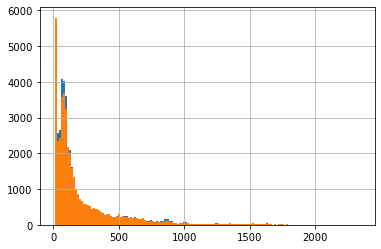

In [21]:
_nonAMP.length.hist(bins=150)
_AMP.length.hist(bins=150)

<AxesSubplot:>

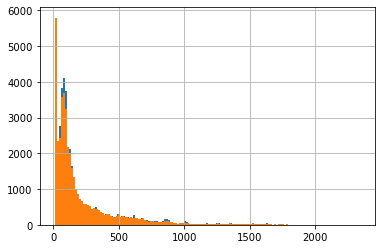

In [13]:
_sub_nonAMP = _nonAMP.sample(frac =.631)
_sub_nonAMP.length.hist(bins=150)
_AMP.length.hist(bins=150)

In [22]:
_AMP['Sequence'] = _AMP.Sequence.astype(str)
_AMP["class"] = 0
_AMP

,ID,Sequence,reps,length,class
0,cluster7485_164,VAVATTMPKGKAEGDPKGDKAKVKDEPQRRSARLSAKPSSPKPEPK...,"[0.5375056368583493, 0.49637201489157845, 0.49...",164,0
1,cluster15088_156,MNKNPDTTTGATNNIARPLRVAMCSKAILALLVYGIIMHCSVYCSP...,"[0.5486437309106742, 0.4952886009862188, 0.495...",156,0
2,cluster658_105,GCAVMAKESMKAREVKRAKLVAKFAEKRAALKAIISDVNVSEEDRW...,"[0.5717629583353222, 0.49111998143773133, 0.48...",105,0
3,cluster3411_104,MAGRSGDSDEDLLKTVRLIKTLYQSNPPPNPEGTRQARRNRRRRWR...,"[0.5069707021785194, 0.4993269234834905, 0.499...",104,0
4,cluster11733_671,MQPAVFLGLLGAAVVAAVSSVPVDNRNHNEEMVTRCIIEVLSNALS...,"[0.5327177133675224, 0.4954472197215189, 0.497...",671,0
...,...,...,...,...,...
43216,cluster10459_186,MSTALPGVPPRPEHKPWRARGPALFWSPQTQKEPTMVLSPADKSNV...,"[0.538899724867421, 0.4962366302094359, 0.4962...",186,0
43217,cluster11453_20,TGMAALEQYLGSGHAVIVSI,"[0.5541616527636486, 0.4947501929289918, 0.494...",20,0
43218,cluster15897_483,MKLLLILGVALVLLFGESLGQRFSQPTFKLPQGRLTLSRKFRESGN...,"[0.5142559694449927, 0.49862319188565063, 0.49...",483,0
43219,cluster352_412,MEYSSHQFDVIVVGAGIMGSSTAYQLAKRGQKTLLLEQFDFLHHRG...,"[0.534496081181401, 0.49120236437650516, 0.492...",412,0


In [23]:
final_arr= _AMP.append(_nonAMP, ignore_index = True)
output = open('/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pssm.pkl', 'wb')
pickle.dump(final_arr, output)
output.close()
final_arr

,ID,Sequence,reps,length,class
0,cluster7485_164,VAVATTMPKGKAEGDPKGDKAKVKDEPQRRSARLSAKPSSPKPEPK...,"[0.5375056368583493, 0.49637201489157845, 0.49...",164,0
1,cluster15088_156,MNKNPDTTTGATNNIARPLRVAMCSKAILALLVYGIIMHCSVYCSP...,"[0.5486437309106742, 0.4952886009862188, 0.495...",156,0
2,cluster658_105,GCAVMAKESMKAREVKRAKLVAKFAEKRAALKAIISDVNVSEEDRW...,"[0.5717629583353222, 0.49111998143773133, 0.48...",105,0
3,cluster3411_104,MAGRSGDSDEDLLKTVRLIKTLYQSNPPPNPEGTRQARRNRRRRWR...,"[0.5069707021785194, 0.4993269234834905, 0.499...",104,0
4,cluster11733_671,MQPAVFLGLLGAAVVAAVSSVPVDNRNHNEEMVTRCIIEVLSNALS...,"[0.5327177133675224, 0.4954472197215189, 0.497...",671,0
...,...,...,...,...,...
86452,UniRef50_D8ND86,MVFTRYADDLTFSSRDETLGRAACRELIGEVGDLLRQRGFNPKHKK...,"[0.5367091908318847, 0.4964493350494845, 0.496...",138,1
86453,UniRef50_A0A1Z3FT13,TNNGSRFNMLRIHLYPQFKFCE,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",22,1
86454,UniRef50_J7RWA0,MIEMECDVKHIK,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",12,1
86455,UniRef50_A0A351U7N6,MIGAYGATGDDPGPNASYPLVTVVEPDKEVWTFSADASSNRTLKIE...,"[0.5219555691326374, 0.49787880060467044, 0.49...",429,1


## solution 2 padding

--> https://www.nature.com/articles/s41598-020-71450-8